<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-NLP/blob/master/Sentiment_Analysis_StockTrendPrediction_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google News Scraping
In this notebook you can find the necessary code to retrieve articles for given keywords on a date range

In [39]:
!pip install bert-for-tf2
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install yfinance
!pip install news-please
!pip install google

In [40]:
from newsplease import NewsPlease
from googlesearch import search, get_tbs
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import logging

In [41]:
start = "2019-01-01"
end   = "2020-03-19"

In [42]:
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

In [43]:
df = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df["Close"].tail()

,BTC-USD,TSLA
Date,,
2020-03-15,5392.314941,NaN
2020-03-16,5014.479980,445.070007
2020-03-17,5225.629395,430.200012
2020-03-18,5238.438477,361.220001
2020-03-19,6191.192871,NaN


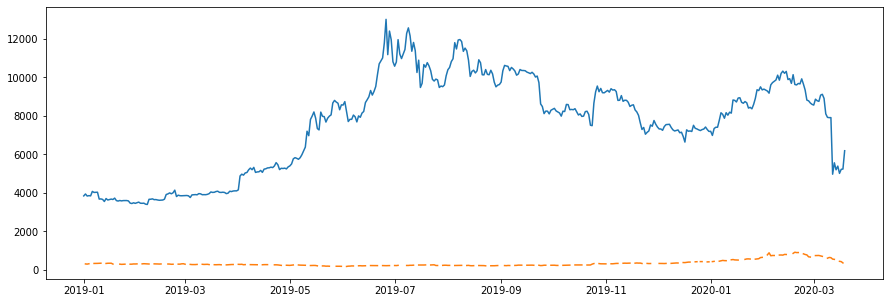

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df["Close"])

Google news

In [45]:
start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end, "%Y-%m-%d")

In [46]:
def find_urls(search_term, tbs, number):
    results =  search(search_term ,lang = "en",tbs = tbs, country = "usa", tpe = "nws", stop=number)
    urls = []
    for url in results:
        urls.append(url)
    return urls

In [47]:
def detect_empty_articles(articles):
    empty = []
    for url in articles:
        article = articles.get(url)
        if (article.maintext == None and article.text == None):
            empty.append(url)
    for k in empty:
        articles.pop(k)
    return empty, articles

In [48]:
def download_articles(search_term, n_articles, start, end = None):
    start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
    end_date = start_date if end is None else datetime.datetime.strptime(end, "%Y-%m-%d")
    tbs = get_tbs(start_date,end_date)

    urls = find_urls(search_term, tbs, 10)
    valid_articles = []
    while (len(valid_articles) < n_articles and len(urls) > 0):
        articles_left = 5 - len(valid_articles)
        articles = NewsPlease.from_urls(urls[:articles_left])
        empty, articles = detect_empty_articles(articles)
        for new in articles:
            valid_articles.append(articles.get(new))
        urls = urls[articles_left:]
    #print("valid_articles", len(valid_articles))
    return {"search_term": search_term ,"start": start, "end": start if end is None else end,"articles" : valid_articles}

In [49]:
def prepare_entries(articles_dict):
    entries = []
    articles, search_term, start = articles_dict["articles"], articles_dict["search_term"], articles_dict["start"]
    for art in articles:
        text = art.maintext if art.maintext != None else art.text
        entry = {
            "date_google" : start,
            "date_article": art.date_publish.strftime("%Y-%m-%d") if art.date_publish is not None else None,
            "search_term" : search_term,
            "authors" : ",".join(art.authors) if art.authors is not None else None,
            "source_domain" : art.source_domain,
            "title" : art.title,
            "description" : art.description,
            "url" : art.url,
            "maintext" : text
        }
        entries.append(entry)
    #print("Entries: ", len(entries))
    return entries

In [50]:
def search_articles_for_each_day(search_term, start, end):
    dates = pd.date_range(start, end).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
    all_entries = []
    errors = []
    for date in dates:
        try:
            articles_dict = download_articles(search_term, 5, date)
            entries = prepare_entries(articles_dict)
            all_entries.extend(entries)
        except Exception as ex:
            errors.append({"search_term" : search_term, "date" : date})
            logging.exception("Could not retrieve articles with search_term = {} for date {}".format(search_term, date))
    df = pd.DataFrame(all_entries)
    errors_df = pd.DataFrame(errors)
    return df, errors_df

In [51]:

def search_articles_for_keywords(keywords, start, end):
    for k in keywords:
        search_term = " | ".join(keywords.get(k))
        df, errors = search_articles_for_each_day(search_term, start, end)
        df.to_csv("/content/drive/My Drive/ColabData/{} start:{} end:{}.csv".format(search_term,start,end))
        errors.to_csv("/content/drive/My Drive/ColabData/Errors- {} start:{} end:{}.csv".format(search_term,start,end))

In [52]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# !ls "/content/drive/My Drive"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
search_articles_for_keywords(keywords, "2019-01-01", "2019-01-03")

Exception in thread Thread-86:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/newsplease/crawler/simple_crawler.py", line 31, in _fetch_url
    html = urllib.request.urlopen(req, data=None, timeout=timeout).read()
  File "/usr/lib/python3.6/urllib/request.py", line 223, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python3.6/urllib/request.py", line 532, in open
    response = meth(req, response)
  File "/usr/lib/python3.6/urllib/request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "/usr/lib/python3.6/urllib/request.py", line 570, in error
    return self._call_chain(*args)
  File "/usr/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.6/u